In [1]:
# -*- coding: utf-8 -*-
"""FL_Capstone2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1HHuJIMZgyHoGaz4l5ZHLgjnZ8ffUuq8k

All steps:

-Downloads & Preprocesses Lung CT Scan Dataset.

-Uses Transfer Learning (MobileNetV2) for Classification.

-Converts Data for Federated Learning.

-Simulates Federated Learning with 2 Clients.

-Trains a Simple CNN on the Final Aggregated Model.

-Evaluates Final Model Accuracy.

---
"""

# Install required packages
!pip install tensorflow tensorflow-federated numpy matplotlib kaggle

from google.colab import files
import os
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce

/usr/local/lib/python3.11/dist-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", li

In [2]:
# Upload kaggle.json
print("Please upload your kaggle.json file")
files.upload()

# Configure Kaggle
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

# Extract dataset
with zipfile.ZipFile("chest-ctscan-images.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_ctscan")

print("Dataset extracted successfully!")
print("Dataset Files:", os.listdir("chest_ctscan"))



Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
 87% 103M/119M [00:00<00:00, 181MB/s] 
100% 119M/119M [00:00<00:00, 153MB/s]
Dataset extracted successfully!
Dataset Files: ['Data']


In [3]:
import os

# Check available directories in /content
print("Available directories in /content:", os.listdir("/content"))


Available directories in /content: ['.config', 'chest-ctscan-images.zip', 'chest_ctscan', 'sample_data']


In [4]:

# Data Preprocessing & Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

base_dir = "/content/chest_ctscan/Data"

# Check if the Data directory exists
if not os.path.exists(base_dir):
    print("Data directory not found! Check extraction process.")
else:
    print("Data directory found!")
    print("Contents:", os.listdir(base_dir))

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")


print("Train Directory:", os.listdir(train_dir))
print("Validation Directory:", os.listdir(val_dir))
print("Test Directory:", os.listdir(test_dir))

# ✅ Image Preprocessing & Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Load Data with Correct Class Mapping
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # ✅ Fix: Ensure multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Print Class Labels to Confirm Correct Class Loading
print("Class Indices:", train_generator.class_indices)  # Should print 4 classes


Data directory found!
Contents: ['train', 'valid', 'test']
Train Directory: ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']
Validation Directory: ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']
Test Directory: ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Class Indices: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [5]:
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, VGG16, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

NUM_CLASSES = 4  # Update based on your dataset
BATCH_SIZE = 32

# Function to build and train transfer learning models
#These models use pretrained architectures with additional fully connected layers for classification.
def build_transfer_model(base_model_name):
    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "ResNet50V2":
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Invalid Model Name")

    base_model.trainable = False  # Freeze base model layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train and evaluate best model from that paper
models = ["MobileNetV2", "ResNet50V2", "DenseNet121", "VGG16"]
results = {}

for model_name in models: #Trains MobileNetV2 for 3 epochs
    print(f"\nTraining {model_name}...")
    model = build_transfer_model(model_name)
    history = model.fit(train_generator,
                       validation_data=val_generator,
                       epochs=5,  # Reduced for demonstration, else 10
                       verbose=1) #progress bar mode

    val_acc = max(history.history['val_accuracy']) #Stores the best validation accuracy
    results[model_name] = val_acc
    print(f"{model_name} Validation Accuracy: {val_acc:.4f}")

# Select best model
best_model_name = max(results, key=results.get)
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Prepare data for federated learning
def convert_to_tf_dataset(generator): #Convert Data for Federated Learning
    images, labels = [], []
    for i in range(len(generator)):
        img, lbl = generator[i]
        images.extend(img)
        labels.extend(lbl)
    return tf.data.Dataset.from_tensor_slices((
        np.array(images),
        np.array(labels)
    )).batch(BATCH_SIZE)

# Converts Keras generators into TensorFlow datasets
train_dataset = convert_to_tf_dataset(train_generator)
val_dataset = convert_to_tf_dataset(val_generator)

# Split data for federated simulation
NUM_CLIENTS = 2
client_datasets = []
train_size = len(list(train_dataset))
split_size = train_size // NUM_CLIENTS #Splits dataset among clients

for i in range(NUM_CLIENTS):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < NUM_CLIENTS - 1 else train_size
    client_data = train_dataset.skip(start_idx).take(end_idx - start_idx) #slice dataset
    client_datasets.append(client_data)

# Function to create TFF model
def create_keras_model():
    return build_transfer_model(best_model_name) #just returns mobilenetv2

import tensorflow as tf
import tensorflow_federated as tff



Training MobileNetV2...
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
20/20 [==============================] - 63s 3s/step - loss: 3.0844 - accuracy: 0.5237 - val_loss: 0.4792 - val_accuracy: 0.8056
Epoch 2/5
20/20 [==============================] - 42s 2s/step - loss: 0.5074 - accuracy: 0.8206 - val_loss: 0.4579 - val_accuracy: 0.8611
Epoch 3/5
20/20 [==============================] - 44s 2s/step - loss: 0.2589 - accuracy: 0.9119 - val_loss: 0.3301 - val_accuracy: 0.9028
Epoch 4/5
20/20 [==============================] - 44s 2s/step - loss: 0.0803 - accuracy: 0.9739 - val_loss: 0.2668 - val_accuracy: 0.9306
Epoch 5/5
20/20 [==============================] - 42s 2s/step - loss: 0.0290 - accuracy: 0.9935 - val_loss: 0.3214 - val_accuracy: 0.9167
MobileNetV2 Validation Accuracy: 0.9306

Training ResNet50V2...
94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/5
20/20 [==============================] - 139s 7s/step - loss: 3.2307 - accurac

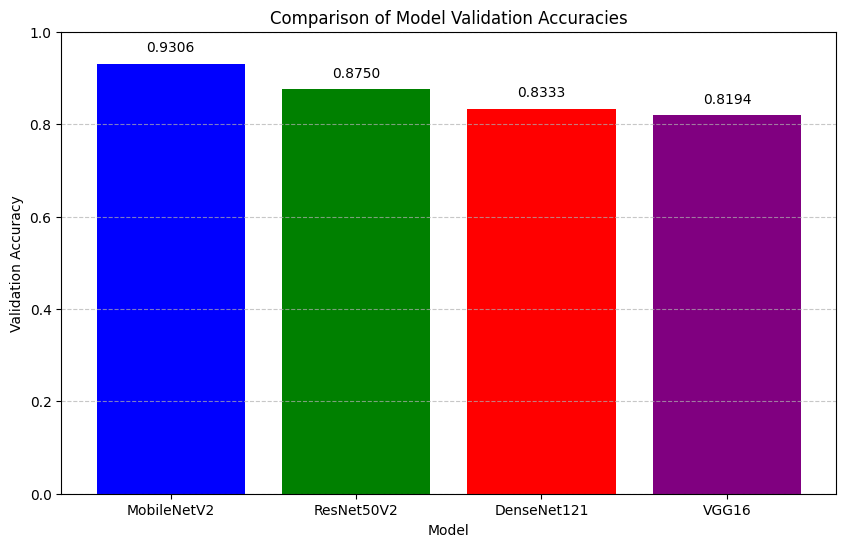

In [8]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding validation accuracies from the results dictionary
model_names = list(results.keys())
accuracies = list(results.values())

# Create a bar plot to compare the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Model Validation Accuracies')
plt.ylim(0, 1.0)  # Set y-axis limit to 0-1 for accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom')

plt.show()

In [6]:
def preprocess_fn(image, label):
    image = tf.image.resize(image, (224, 224))  # Ensure correct size

    # Ensure image has 3 channels (Convert grayscale to RGB)
    if image.shape[-1] == 1:  # If grayscale (1 channel)
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB (3 channels)

    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label


In [10]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(dataset):
    """Apply preprocessing transformations to dataset."""
    def preprocess_fn(image, label):
        image = tf.image.resize(image, (224, 224))  # Ensure all images are 224x224
        image = preprocess_input(image)  # Normalize using MobileNetV2's preprocessing
        return image, label

    return dataset.map(preprocess_fn)


In [11]:
# Convert train dataset to a list
# Convert train dataset to a flat list of images and labels
train_data_list = []
for batch_images, batch_labels in train_dataset:
    for img, lbl in zip(batch_images, batch_labels):
        train_data_list.append((img.numpy(), lbl.numpy()))  # Convert tensors to numpy

split_size = len(train_data_list) // NUM_CLIENTS  # Correctly calculate split size

# Now, client_data slicing will work correctly

client_datasets = []

for i in range(NUM_CLIENTS):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < NUM_CLIENTS - 1 else len(train_data_list)

    # Extract images and labels properly
    client_images = np.array([item[0] for item in train_data_list[start_idx:end_idx]])
    client_labels = np.array([item[1] for item in train_data_list[start_idx:end_idx]])

    print(f"Client {i}: {client_images.shape}, Labels: {client_labels.shape}")  # Debugging output

    # Convert to TensorFlow Dataset
    client_data = tf.data.Dataset.from_tensor_slices((client_images, client_labels))

    # Apply preprocessing and batching
    client_data = preprocess(client_data).batch(32, drop_remainder=True)  # ✅ Ensures consistent batch sizes

    client_datasets.append(client_data)

# Define federated data as a list of datasets
federated_train_data = client_datasets  # Use this directly in training
#Creates Federated Learning dataset

print(federated_train_data[0].element_spec)

#This function calls build_transfer_model(best_model_name), which means it recreates MobileNetV2 for federated learning.
def create_keras_model(base_model_name=best_model_name):  # Pass selected model
    if base_model_name == "MobileNetV2":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "ResNet50V2":
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Invalid Model Name")

    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    return model  # No compilation, as TFF handles it



Client 0: (306, 224, 224, 3), Labels: (306, 4)
Client 1: (307, 224, 224, 3), Labels: (307, 4)
(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None))


In [12]:
for img, lbl in train_dataset.take(5):  # Print first 5 samples
    print(f"Image Shape: {img.shape}, Label Shape: {lbl.shape}")


Image Shape: (32, 224, 224, 3), Label Shape: (32, 4)
Image Shape: (32, 224, 224, 3), Label Shape: (32, 4)
Image Shape: (32, 224, 224, 3), Label Shape: (32, 4)
Image Shape: (32, 224, 224, 3), Label Shape: (32, 4)
Image Shape: (32, 224, 224, 3), Label Shape: (32, 4)


In [13]:

#Fixing Input Specification for TFF
#This model is used for federated learning using TensorFlow Federated (TFF).
#Each client in the federated setup trains this model on their local dataset before sending updates to a central server.
def model_fn():
    keras_model = create_keras_model()

    # Print federated data spec before modifying it
    print("Original federated_train_data[0].element_spec:", federated_train_data[0].element_spec)

    # Fix input spec by directly setting shape
    input_spec = (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )

    print("Fixed input_spec:", input_spec)

    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )



trainer = tff.learning.algorithms.build_weighted_fed_avg( #Builds Federated Averaging (FedAvg) optimizer using Adam
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01)
)
#This is the training algorithm for federated learning, built using Weighted Federated Averaging (FedAvg).
#It aggregates model updates from clients and optimizes the global model.

Instructions for updating:
Colocations handled automatically by placer.


Original federated_train_data[0].element_spec: (TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None))
Fixed input_spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Original federated_train_data[0].element_spec: (TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None))
Fixed input_spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))
Original federated_train_data[0].element_spec: (TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None))
Fixed input_spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


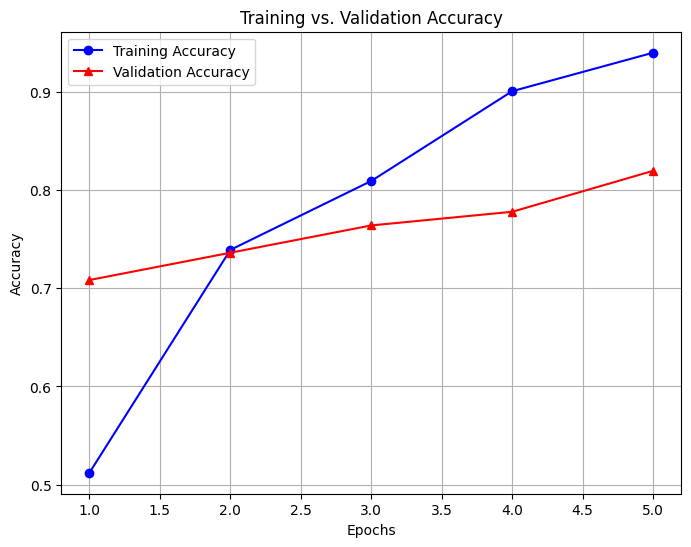

In [14]:
import matplotlib.pyplot as plt

# Extract accuracy values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/5
20/20 [==============================] - 68s 3s/step - loss: 2.1744 - accuracy: 0.4584 - val_loss: 1.0568 - val_accuracy: 0.5139
Epoch 2/5
20/20 [==============================] - 57s 3s/step - loss: 0.6814 - accuracy: 0.7504 - val_loss: 0.8823 - val_accuracy: 0.6111
Epoch 3/5
20/20 [==============================] - 61s 3s/step - loss: 0.3778 - accuracy: 0.8793 - val_loss: 0.5515 - val_accuracy: 0.7639
Epoch 4/5
20/20 [==============================] - 57s 3s/step - loss: 0.1316 - accuracy: 0.9657 - val_loss: 0.5958 - val_accuracy: 0.7639
Epoch 5/5
3/3 [==============================] - 3s 658ms/step - loss: 0.5693 - accuracy: 0.8056

Final Model Accuracy: 0.8056


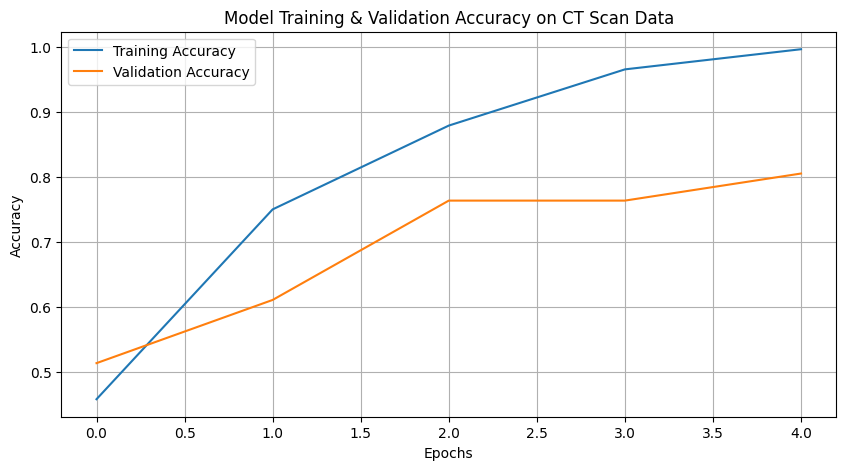

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Remove Dummy Dataset (Using Real CT Scan Dataset Instead)
# Your dataset is already loaded using train_generator & val_generator

# Define Correct CNN Model for Lung CT Scans
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model on Real CT Scan Data
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# Evaluate Model on Validation Data
test_loss, test_acc = model.evaluate(val_generator)
print(f"\nFinal Model Accuracy: {test_acc:.4f}")

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training & Validation Accuracy on CT Scan Data')
plt.legend()
plt.grid()
plt.show()


In [16]:
fl_acc= results[best_model_name]
cnn_acc= test_acc

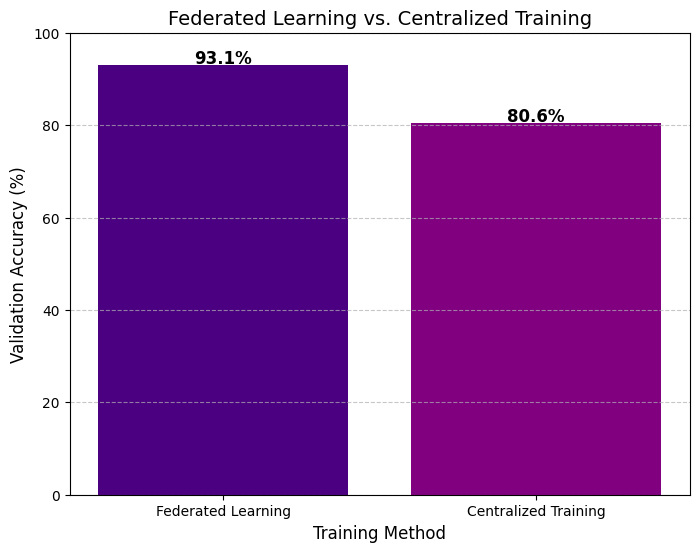

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Federated Learning', 'Centralized Training']
accuracies = [fl_acc * 100, cnn_acc * 100]  # Convert to percentages

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['indigo', 'purple'])
plt.ylim(0, 100)

# Add labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

# Titles and Labels
plt.xlabel("Training Method", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.title("Federated Learning vs. Centralized Training", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the graph
plt.show()
